Sina Hatami 5447389

In [ ]:
import numpy as np
from scipy.interpolate import griddata
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D

from keras.utils import to_categorical

import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Instructions on using Keras

Models in Keras are defined as a sequence of layers.

We create a [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) object which holds multiple layers executed one by one, and add layers to the object until we have formed the architecture.

To create the first layer, you need to know the right number of input features. You can specify this by using the `input_dim` argument. 

The things to choose when defining the architecture are many:
 - number of layers
 - type of layers
 - size of layers
 - type of non-linearity
 - whether or not to add regularization
 
Here we will use only fully-connected (dense) layers, so the type of layer is fixed. Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class, which takes as parameters the number of neurons (which is the **dimension of the output**).

The activation functions are used after each dense layer. You can choose the activation functions for hidden layers yourself, a common choice being the [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) activation. But for the last layer, the activation must reflect the range of the outputs.

Since we will work with binary classification problem, the output should be between 0 and 1, which is then easy to map to any given class. To ensure this we can use the [Sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) activation.


After having created a model you need to **compile** it. During the compilation phase you must specify some parameters related to how the model will be optimized:
 - The `optimizer`. For the following exercise you should use [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD), initialized with some learning rate (instructions on how to choose it follow).
 - The `loss` function. For binary classification you can use the [cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss.
 - A list of `metrics`: common error functions which you want keras to report at each training epoch.
 
Then you may actually train the model by calling **fit**. The fit function takes as input the training data, and some more parameters related to the training process:
 - `epochs` : the number of epochs to train for
 - `batch_size` : the size of mini-batches. A high batch-size will speed up computations but may make training unstable.
 
Other useful functions are `model.predict` which runs the model's forward pass to predict on new samples, and `model.evaluate` which is similar to `predict` but instead of giving predictions as output, it simply computes some metrics.

In [104]:
# !pip install tensorflow

In [105]:
def generate_2d_cls_data(n, sigma_noise):
    n_cls = n // 2
    
    theta = np.random.randn(n_cls) * 2 * np.pi
    cls1 = np.stack([np.cos(theta) * 2, np.sin(theta) * 2], axis=1)
    cls2 = np.random.randn(n_cls, 2) * 0.5

    cls1 += np.random.randn(cls1.shape[0], 2) * sigma_noise * 3
    cls2 += np.random.randn(cls2.shape[0], 2) * sigma_noise
    
    X = np.concatenate([cls1, cls2], axis=0)
    y = np.concatenate([np.zeros(n_cls), np.ones(n_cls)], axis=0)
    
    return X, y

In [106]:
def separatingFLR(data, labels, predictions, model):
    fig, ax = plt.subplots()
    
    num_grid_points = 100
    xi = np.linspace(data[:, 0].min(), data[:, 0].max(), num_grid_points)
    yi = np.linspace(data[:, 1].min(), data[:, 1].max(), num_grid_points)
    gdata = np.stack([xi, yi], 1)
    X, Y = np.meshgrid(xi,yi)
    pred_grid = model.predict(
        np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
    ).reshape(num_grid_points, num_grid_points)
    
    ax.contour(xi, yi, pred_grid, 15, linewidths=2, colors='k', levels=[0.5])
    # plot data points.
    ax.scatter(data[:,0], data[:,1], c=labels.ravel(), marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(data[:,0].min(), data[:,0].max())
    ax.set_ylim(data[:,1].min(), data[:,1].max())
    return fig, ax

In [107]:
def calc_err(predicted, observed):
    predicted = predicted.ravel()
    observed = observed.ravel()
    threshold_preds = predicted.copy()
    threshold_preds[predicted < 0.5] = 0
    threshold_preds[predicted >= 0.5] = 1
    return np.mean(threshold_preds != observed)

### Synthetic Example

#### Generating the train and test sets

Note that with neural nets, the labels for binary classification should be 0 and +1.

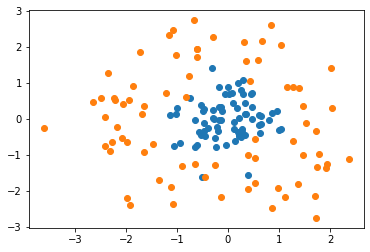

In [108]:
np.random.seed(34)
Xtr, Ytr = generate_2d_cls_data(150, 0.2)
Xte, Yte = generate_2d_cls_data(100, 0.2)

fig, ax = plt.subplots()
ax.scatter(Xtr[Ytr == 1,0], Xtr[Ytr == 1, 1])
ax.scatter(Xtr[Ytr == 0,0], Xtr[Ytr == 0, 1])

In [109]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Build your first model by creating a Sequential object and then adding 3 Dense layers:
model = Sequential()
model.add(Dense(4, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=600,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/600
12/12 [==============================] - 0s 11ms/step - loss: 0.7486 - accuracy: 0.4083 - val_loss: 0.7373 - val_accuracy: 0.3000
Epoch 2/600
12/12 [==============================] - 0s 4ms/step - loss: 0.6687 - accuracy: 0.4750 - val_loss: 0.8022 - val_accuracy: 0.0000e+00
Epoch 3/600
12/12 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6167 - val_loss: 0.8460 - val_accuracy: 0.0000e+00
Epoch 4/600
12/12 [==============================] - 0s 4ms/step - loss: 0.5980 - accuracy: 0.6250 - val_loss: 0.8710 - val_accuracy: 0.0000e+00
Epoch 5/600
12/12 [==============================] - 0s 4ms/step - loss: 0.5793 - accuracy: 0.6250 - val_loss: 0.8874 - val_accuracy: 0.0000e+00
Epoch 6/600
12/12 [==============================] - 0s 4ms/step - loss: 0.5652 - accuracy: 0.6250 - val_loss: 0.8968 - val_accuracy: 0.0000e+00
Epoch 7/600
12/12 [==============================] - 0s 3ms/step - loss: 0.5533 - accuracy: 0.6250 - val_loss: 0.8978 - val_accuracy:

Epoch 116/600
12/12 [==============================] - 0s 5ms/step - loss: 0.2107 - accuracy: 0.9333 - val_loss: 0.3465 - val_accuracy: 0.8667
Epoch 117/600
12/12 [==============================] - 0s 4ms/step - loss: 0.2101 - accuracy: 0.9333 - val_loss: 0.3484 - val_accuracy: 0.8667
Epoch 118/600
12/12 [==============================] - 0s 4ms/step - loss: 0.2094 - accuracy: 0.9333 - val_loss: 0.3463 - val_accuracy: 0.8667
Epoch 119/600
12/12 [==============================] - 0s 4ms/step - loss: 0.2083 - accuracy: 0.9333 - val_loss: 0.3441 - val_accuracy: 0.8667
Epoch 120/600
12/12 [==============================] - 0s 4ms/step - loss: 0.2081 - accuracy: 0.9333 - val_loss: 0.3437 - val_accuracy: 0.8667
Epoch 121/600
12/12 [==============================] - 0s 4ms/step - loss: 0.2065 - accuracy: 0.9333 - val_loss: 0.3445 - val_accuracy: 0.8667
Epoch 122/600
12/12 [==============================] - 0s 4ms/step - loss: 0.2067 - accuracy: 0.9417 - val_loss: 0.3427 - val_accuracy: 0.8667

12/12 [==============================] - 0s 3ms/step - loss: 0.1686 - accuracy: 0.9417 - val_loss: 0.3052 - val_accuracy: 0.8667
Epoch 231/600
12/12 [==============================] - 0s 4ms/step - loss: 0.1686 - accuracy: 0.9417 - val_loss: 0.3079 - val_accuracy: 0.8667
Epoch 232/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1688 - accuracy: 0.9333 - val_loss: 0.3057 - val_accuracy: 0.8667
Epoch 233/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1680 - accuracy: 0.9417 - val_loss: 0.3079 - val_accuracy: 0.8667
Epoch 234/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1676 - accuracy: 0.9417 - val_loss: 0.3039 - val_accuracy: 0.8667
Epoch 235/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1679 - accuracy: 0.9417 - val_loss: 0.3070 - val_accuracy: 0.8667
Epoch 236/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1672 - accuracy: 0.9417 - val_loss: 0.3062 - val_accuracy: 0.8667
Epoch 237/600

12/12 [==============================] - 0s 3ms/step - loss: 0.1547 - accuracy: 0.9417 - val_loss: 0.3048 - val_accuracy: 0.8667
Epoch 345/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1543 - accuracy: 0.9417 - val_loss: 0.3074 - val_accuracy: 0.8667
Epoch 346/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1538 - accuracy: 0.9417 - val_loss: 0.3088 - val_accuracy: 0.8667
Epoch 347/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1546 - accuracy: 0.9417 - val_loss: 0.3082 - val_accuracy: 0.8667
Epoch 348/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1540 - accuracy: 0.9417 - val_loss: 0.3087 - val_accuracy: 0.8667
Epoch 349/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1537 - accuracy: 0.9417 - val_loss: 0.3089 - val_accuracy: 0.8667
Epoch 350/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1533 - accuracy: 0.9417 - val_loss: 0.3054 - val_accuracy: 0.8667
Epoch 351/600

12/12 [==============================] - 0s 3ms/step - loss: 0.1446 - accuracy: 0.9417 - val_loss: 0.3074 - val_accuracy: 0.8667
Epoch 459/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1449 - accuracy: 0.9417 - val_loss: 0.3070 - val_accuracy: 0.8667
Epoch 460/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1442 - accuracy: 0.9417 - val_loss: 0.3069 - val_accuracy: 0.8667
Epoch 461/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1441 - accuracy: 0.9417 - val_loss: 0.3077 - val_accuracy: 0.8667
Epoch 462/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1440 - accuracy: 0.9417 - val_loss: 0.3065 - val_accuracy: 0.8667
Epoch 463/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1441 - accuracy: 0.9417 - val_loss: 0.3066 - val_accuracy: 0.8667
Epoch 464/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1433 - accuracy: 0.9417 - val_loss: 0.3069 - val_accuracy: 0.8667
Epoch 465/600

12/12 [==============================] - 0s 3ms/step - loss: 0.1343 - accuracy: 0.9417 - val_loss: 0.2812 - val_accuracy: 0.8667
Epoch 573/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1340 - accuracy: 0.9417 - val_loss: 0.2797 - val_accuracy: 0.8667
Epoch 574/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1340 - accuracy: 0.9417 - val_loss: 0.2792 - val_accuracy: 0.8667
Epoch 575/600
12/12 [==============================] - 0s 5ms/step - loss: 0.1336 - accuracy: 0.9417 - val_loss: 0.2804 - val_accuracy: 0.8667
Epoch 576/600
12/12 [==============================] - 0s 5ms/step - loss: 0.1339 - accuracy: 0.9417 - val_loss: 0.2791 - val_accuracy: 0.8667
Epoch 577/600
12/12 [==============================] - 0s 5ms/step - loss: 0.1337 - accuracy: 0.9417 - val_loss: 0.2789 - val_accuracy: 0.8667
Epoch 578/600
12/12 [==============================] - 0s 4ms/step - loss: 0.1342 - accuracy: 0.9417 - val_loss: 0.2771 - val_accuracy: 0.8667
Epoch 579/600

#### Plot the results from the model

In [110]:
# With this function you can plot the history of the model training produced by the fit function
def plot_history(history):
    fig, ax = plt.subplots()
    # Plot training & validation accuracy values
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Val')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    return fig, ax

313/313 [==============================] - 0s 843us/step


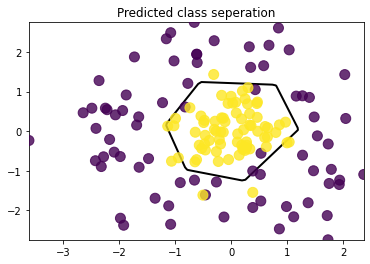

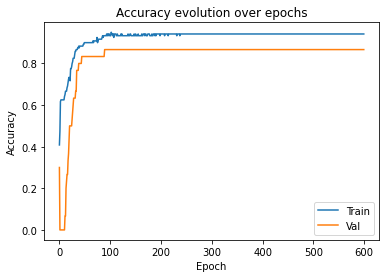

In [111]:
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

## Exploring Different Architectures

Using a simple binary classification dataset you will build a keras model with Dense layers, and the RELU activation function.

You will explore different architectures to try and see when the NN overfits or underfits the data.

In particular, you should try the following:
 1. A NN with a single hidden layer with many (e.g. 100) neurons
 2. A NN with many (e.g. 3, 4, 5) hidden layers with a few neurons (e.g. 10 to 30).
 
Train the neural network using the SGD algorithm with a learning rate of 0.05 (you may explore different values) for 500 epochs (or less if time doesn't permit).

For each setting you try, plot the training and validation errors as a function of the epochs, and plot the separating function (use the `separatingFLR` function).

For each setting comment on whether the NN is overfitting or not. Further comment on which model you believe is better, and why (e.g. computational or accuracy considerations).

We provide some skeleton code to train and evaluate a model, you'll have to fill it in, and do the same thing multiple times for different models.

#### 1) NN with single layer with 100 neurons

In [112]:
# Build your first model by creating a Sequential object and then adding 3 Dense layers:
model = Sequential()

# Add layers
model.add(Dense(100, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)


# Fit model
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=600,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)


# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/600
12/12 [==============================] - 0s 11ms/step - loss: 0.7460 - accuracy: 0.3417 - val_loss: 0.7690 - val_accuracy: 0.0000e+00
Epoch 2/600
12/12 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6167 - val_loss: 0.8557 - val_accuracy: 0.0000e+00
Epoch 3/600
12/12 [==============================] - 0s 3ms/step - loss: 0.5980 - accuracy: 0.6250 - val_loss: 0.9012 - val_accuracy: 0.0000e+00
Epoch 4/600
12/12 [==============================] - 0s 3ms/step - loss: 0.5725 - accuracy: 0.6250 - val_loss: 0.9242 - val_accuracy: 0.0000e+00
Epoch 5/600
12/12 [==============================] - 0s 3ms/step - loss: 0.5533 - accuracy: 0.6250 - val_loss: 0.9339 - val_accuracy: 0.0000e+00
Epoch 6/600
12/12 [==============================] - 0s 4ms/step - loss: 0.5385 - accuracy: 0.6250 - val_loss: 0.9257 - val_accuracy: 0.0000e+00
Epoch 7/600
12/12 [==============================] - 0s 3ms/step - loss: 0.5258 - accuracy: 0.6250 - val_loss: 0.9163 - val_accur

Epoch 116/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1572 - accuracy: 0.9500 - val_loss: 0.2520 - val_accuracy: 0.9333
Epoch 117/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1566 - accuracy: 0.9500 - val_loss: 0.2519 - val_accuracy: 0.9333
Epoch 118/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1559 - accuracy: 0.9500 - val_loss: 0.2494 - val_accuracy: 0.9333
Epoch 119/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1554 - accuracy: 0.9500 - val_loss: 0.2519 - val_accuracy: 0.9333
Epoch 120/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1557 - accuracy: 0.9500 - val_loss: 0.2511 - val_accuracy: 0.9333
Epoch 121/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1551 - accuracy: 0.9500 - val_loss: 0.2526 - val_accuracy: 0.9000
Epoch 122/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1540 - accuracy: 0.9500 - val_loss: 0.2511 - val_accuracy: 0.9000

12/12 [==============================] - 0s 3ms/step - loss: 0.1252 - accuracy: 0.9500 - val_loss: 0.2424 - val_accuracy: 0.9000
Epoch 231/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1260 - accuracy: 0.9500 - val_loss: 0.2398 - val_accuracy: 0.9333
Epoch 232/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1249 - accuracy: 0.9500 - val_loss: 0.2426 - val_accuracy: 0.9000
Epoch 233/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1253 - accuracy: 0.9500 - val_loss: 0.2403 - val_accuracy: 0.9000
Epoch 234/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1249 - accuracy: 0.9500 - val_loss: 0.2362 - val_accuracy: 0.9333
Epoch 235/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1260 - accuracy: 0.9500 - val_loss: 0.2381 - val_accuracy: 0.9333
Epoch 236/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1264 - accuracy: 0.9500 - val_loss: 0.2416 - val_accuracy: 0.9000
Epoch 237/600

12/12 [==============================] - 0s 3ms/step - loss: 0.1152 - accuracy: 0.9583 - val_loss: 0.2366 - val_accuracy: 0.9000
Epoch 345/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1153 - accuracy: 0.9500 - val_loss: 0.2307 - val_accuracy: 0.9000
Epoch 346/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1143 - accuracy: 0.9500 - val_loss: 0.2264 - val_accuracy: 0.9333
Epoch 347/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1134 - accuracy: 0.9583 - val_loss: 0.2323 - val_accuracy: 0.9000
Epoch 348/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1144 - accuracy: 0.9583 - val_loss: 0.2350 - val_accuracy: 0.9000
Epoch 349/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1143 - accuracy: 0.9583 - val_loss: 0.2352 - val_accuracy: 0.9000
Epoch 350/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1127 - accuracy: 0.9583 - val_loss: 0.2320 - val_accuracy: 0.9000
Epoch 351/600

12/12 [==============================] - 0s 3ms/step - loss: 0.1089 - accuracy: 0.9583 - val_loss: 0.2381 - val_accuracy: 0.9000
Epoch 459/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1078 - accuracy: 0.9583 - val_loss: 0.2337 - val_accuracy: 0.9000
Epoch 460/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1084 - accuracy: 0.9500 - val_loss: 0.2325 - val_accuracy: 0.9000
Epoch 461/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1071 - accuracy: 0.9583 - val_loss: 0.2346 - val_accuracy: 0.9000
Epoch 462/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1086 - accuracy: 0.9583 - val_loss: 0.2379 - val_accuracy: 0.9000
Epoch 463/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1085 - accuracy: 0.9583 - val_loss: 0.2390 - val_accuracy: 0.9000
Epoch 464/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1069 - accuracy: 0.9583 - val_loss: 0.2415 - val_accuracy: 0.9000
Epoch 465/600

12/12 [==============================] - 0s 3ms/step - loss: 0.1052 - accuracy: 0.9583 - val_loss: 0.2513 - val_accuracy: 0.9000
Epoch 573/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1043 - accuracy: 0.9583 - val_loss: 0.2479 - val_accuracy: 0.9000
Epoch 574/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1058 - accuracy: 0.9583 - val_loss: 0.2442 - val_accuracy: 0.9000
Epoch 575/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1051 - accuracy: 0.9583 - val_loss: 0.2488 - val_accuracy: 0.9000
Epoch 576/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1041 - accuracy: 0.9500 - val_loss: 0.2496 - val_accuracy: 0.9000
Epoch 577/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1058 - accuracy: 0.9583 - val_loss: 0.2456 - val_accuracy: 0.9000
Epoch 578/600
12/12 [==============================] - 0s 3ms/step - loss: 0.1051 - accuracy: 0.9500 - val_loss: 0.2381 - val_accuracy: 0.9000
Epoch 579/600

313/313 [==============================] - 0s 854us/step


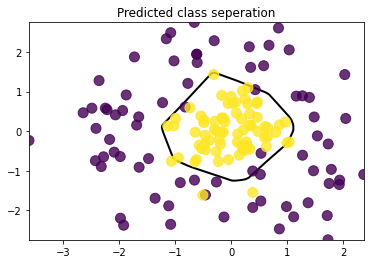

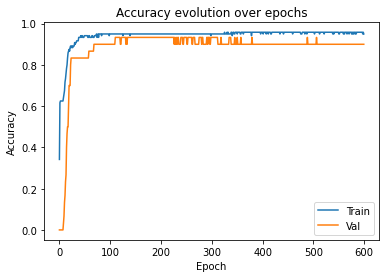

In [113]:
# Plot separating function
ig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

#### 2) NN with 4 hidden layer with  40 neurons

In [114]:
# Repeat the previous code but with 4 hidden layers with 40 neurons (in each layer) 
model = Sequential()

# Add layers
model.add(Dense(40, input_dim=2, activation='relu'))
model.add(Dense(40, input_dim=2, activation='relu'))
model.add(Dense(40, input_dim=2, activation='relu'))
model.add(Dense(40, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)


# Fit model
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=600,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)


# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/600
12/12 [==============================] - 0s 11ms/step - loss: 0.6579 - accuracy: 0.6333 - val_loss: 0.7860 - val_accuracy: 0.0000e+00
Epoch 2/600
12/12 [==============================] - 0s 3ms/step - loss: 0.6118 - accuracy: 0.6250 - val_loss: 0.8495 - val_accuracy: 0.0000e+00
Epoch 3/600
12/12 [==============================] - 0s 3ms/step - loss: 0.5723 - accuracy: 0.6250 - val_loss: 0.8953 - val_accuracy: 0.0000e+00
Epoch 4/600
12/12 [==============================] - 0s 3ms/step - loss: 0.5373 - accuracy: 0.6250 - val_loss: 0.8935 - val_accuracy: 0.0000e+00
Epoch 5/600
12/12 [==============================] - 0s 3ms/step - loss: 0.5004 - accuracy: 0.6250 - val_loss: 0.8703 - val_accuracy: 0.0000e+00
Epoch 6/600
12/12 [==============================] - 0s 3ms/step - loss: 0.4667 - accuracy: 0.7000 - val_loss: 0.8627 - val_accuracy: 0.1667
Epoch 7/600
12/12 [==============================] - 0s 3ms/step - loss: 0.4344 - accuracy: 0.7417 - val_loss: 0.7939 - val_accuracy:

Epoch 116/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0955 - accuracy: 0.9500 - val_loss: 0.2758 - val_accuracy: 0.9333
Epoch 117/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0821 - accuracy: 0.9583 - val_loss: 0.2938 - val_accuracy: 0.9333
Epoch 118/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0734 - accuracy: 0.9750 - val_loss: 0.2064 - val_accuracy: 0.9667
Epoch 119/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0838 - accuracy: 0.9583 - val_loss: 0.3172 - val_accuracy: 0.9333
Epoch 120/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0777 - accuracy: 0.9750 - val_loss: 0.2252 - val_accuracy: 0.9667
Epoch 121/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0770 - accuracy: 0.9667 - val_loss: 0.1675 - val_accuracy: 0.9667
Epoch 122/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0917 - accuracy: 0.9500 - val_loss: 0.1958 - val_accuracy: 0.9667

12/12 [==============================] - 0s 3ms/step - loss: 0.0501 - accuracy: 0.9750 - val_loss: 0.3810 - val_accuracy: 0.9667
Epoch 231/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0445 - accuracy: 0.9833 - val_loss: 0.3453 - val_accuracy: 0.9667
Epoch 232/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0520 - accuracy: 0.9667 - val_loss: 0.3689 - val_accuracy: 0.9667
Epoch 233/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0315 - accuracy: 0.9833 - val_loss: 0.3972 - val_accuracy: 0.9667
Epoch 234/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0452 - accuracy: 0.9667 - val_loss: 0.3901 - val_accuracy: 0.9667
Epoch 235/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0464 - accuracy: 0.9667 - val_loss: 0.3783 - val_accuracy: 0.9667
Epoch 236/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0416 - accuracy: 0.9750 - val_loss: 0.3561 - val_accuracy: 0.9667
Epoch 237/600

12/12 [==============================] - 0s 3ms/step - loss: 0.0166 - accuracy: 0.9917 - val_loss: 0.5137 - val_accuracy: 0.9667
Epoch 345/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.9917 - val_loss: 0.4857 - val_accuracy: 0.9667
Epoch 346/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 0.9917 - val_loss: 0.5417 - val_accuracy: 0.9333
Epoch 347/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0242 - accuracy: 0.9833 - val_loss: 0.5220 - val_accuracy: 0.9333
Epoch 348/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9917 - val_loss: 0.4697 - val_accuracy: 0.9667
Epoch 349/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.5327 - val_accuracy: 0.9667
Epoch 350/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0184 - accuracy: 0.9917 - val_loss: 0.5176 - val_accuracy: 0.9333
Epoch 351/600

12/12 [==============================] - 0s 3ms/step - loss: 0.0101 - accuracy: 0.9917 - val_loss: 0.7610 - val_accuracy: 0.9000
Epoch 459/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.7125 - val_accuracy: 0.9333
Epoch 460/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.6945 - val_accuracy: 0.9333
Epoch 461/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9833 - val_loss: 0.7402 - val_accuracy: 0.9000
Epoch 462/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0098 - accuracy: 0.9917 - val_loss: 0.5710 - val_accuracy: 0.9667
Epoch 463/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0180 - accuracy: 0.9833 - val_loss: 0.5770 - val_accuracy: 0.9667
Epoch 464/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0186 - accuracy: 0.9833 - val_loss: 0.5872 - val_accuracy: 0.9667
Epoch 465/600

12/12 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.7684 - val_accuracy: 0.9333
Epoch 573/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.8118 - val_accuracy: 0.9333
Epoch 574/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.7922 - val_accuracy: 0.9333
Epoch 575/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.8125 - val_accuracy: 0.9333
Epoch 576/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.8007 - val_accuracy: 0.9333
Epoch 577/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.8120 - val_accuracy: 0.9333
Epoch 578/600
12/12 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.8115 - val_accuracy: 0.9333
Epoch 579/600

313/313 [==============================] - 0s 691us/step


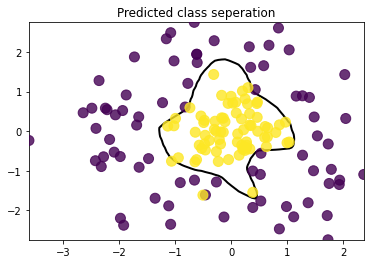

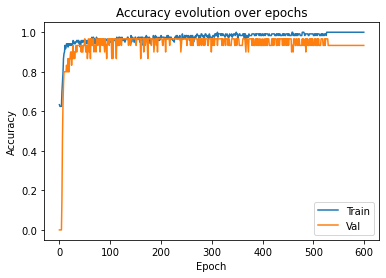

In [115]:
# Plot separating function
ig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

## Train a Neural Network on MNIST!

We can finally switch to a real dataset now.

First we will load the MNIST dataset and plot it to see how it really looks like.

Then we will use the notions learned in the first part to train a model which can distinguish two digits in the MNIST data.

As a bonus, some of you may want to look into multi-class classification and train a model on the whole MNIST dataset!

## Load Data

In [116]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print("Training set shapes: ", x_train.shape, y_train.shape)
print("Test set shapes: ", x_test.shape, y_test.shape)

Training set shapes:  (60000, 28, 28) (60000,)
Test set shapes:  (10000, 28, 28) (10000,)


#### Bring the data into shape

1. Choose the digits we want to classify (variables `num_1` and `num_2`)
2. Then we restrict training and test sets to only use those numbers
3. We reshape the images from 28*28 to a single 784-dimensional vector
4. Finally we modify the labels to their appropriate range (0 and +1)

In [117]:
num_1 = 1
num_2 = 7

# Here we take only two digits from MNIST. 
# We will reduce the problem to binary classification.
Xtr = x_train[(y_train == num_1) | (y_train == num_2)]
Ytr = y_train[(y_train == num_1) | (y_train == num_2)]
Xts = x_test[(y_test == num_1) | (y_test == num_2)]
Yts = y_test[(y_test == num_1) | (y_test == num_2)]

# Reshape the data correctly
Xtr = Xtr.reshape(-1, 28*28)
Xts = Xts.reshape(-1, 28*28)
Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1

We can visualize the images...

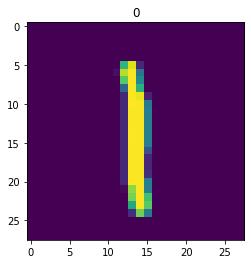

In [118]:
fig, ax = plt.subplots()
ax.imshow(Xtr[3].reshape(28, 28))
ax.set_title(Ytr[3]);

#### Define The Keras Model

In [119]:
model = Sequential()
# Add hidden layers

model.add(Dense(64, input_dim=28*28, activation='relu'))
model.add(Dense(10, activation='relu'))
#model.add(Dense(40, activation='relu'))
#model.add(Dense(40, activation='relu'))



# This is the last layer, it should have 1 neuron and the sigmoid activation
model.add(Dense(1, activation='sigmoid'))  


#### Compile The Keras Model

Here we will use the Adam optimizer instead. It tends to work better than SGD with high dimensional data (such as our MNIST images).

In [120]:
model.compile(
    loss='binary_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    metrics=['accuracy'],)

#### Fit the model

In [121]:
# fit the keras model on the dataset

history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=60,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)


Epoch 1/60
1041/1041 [==============================] - 3s 2ms/step - loss: 0.1714 - accuracy: 0.9838 - val_loss: 0.0329 - val_accuracy: 0.9877
Epoch 2/60
1041/1041 [==============================] - 2s 2ms/step - loss: 0.0246 - accuracy: 0.9913 - val_loss: 0.0256 - val_accuracy: 0.9954
Epoch 3/60
1041/1041 [==============================] - 2s 2ms/step - loss: 0.0156 - accuracy: 0.9955 - val_loss: 0.0199 - val_accuracy: 0.9950
Epoch 4/60
1041/1041 [==============================] - 2s 2ms/step - loss: 0.0116 - accuracy: 0.9957 - val_loss: 0.0124 - val_accuracy: 0.9965
Epoch 5/60
1041/1041 [==============================] - 2s 2ms/step - loss: 0.0143 - accuracy: 0.9958 - val_loss: 0.0316 - val_accuracy: 0.9958
Epoch 6/60
1041/1041 [==============================] - 2s 2ms/step - loss: 0.0129 - accuracy: 0.9963 - val_loss: 0.0142 - val_accuracy: 0.9958
Epoch 7/60
1041/1041 [==============================] - 3s 2ms/step - loss: 0.0172 - accuracy: 0.9958 - val_loss: 0.0109 - val_accuracy:

In [122]:
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

68/68 [==============================] - 0s 891us/step
Training error: 0.62%, Test error: 1.25%


In [123]:
# evaluate the keras model. Is this consistent with the error you computed above?
_, accuracy = model.evaluate(Xts, Yts)
print('Test accuracy: %.2f%%' % (accuracy*100))

68/68 [==============================] - 0s 1ms/step - loss: 0.0496 - accuracy: 0.9875
Test accuracy: 98.75%


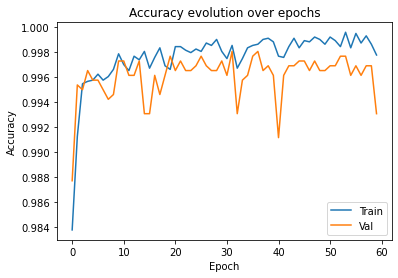

In [124]:
# Plot training history

fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

## Neural Network and Convolutional Neural Network
Implement and compare a Dense neural network and a Convolutional neural network with the following architectures:

1) Neural Network architecture: 3 layers (input, output included) with 18, 8, 1 neurons.

2) Convolutional Neural Network: 2 convolutional layers with:
    - 32 filters 
    - kernel size (3, 3) 
    - stride: first layer= 3, second layer 2  

For both networks use SGD optimizer with learning rate 0.001, batch size of 128 and 50 epochs. Note that the number of parameters of the CNN is about 10k while the number of parameters of the dense neural network is about 12k.

Convolutional layers are implemented with the class [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

In [125]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print("Training set shapes: ", x_train.shape, y_train.shape)
print("Test set shapes: ", x_test.shape, y_test.shape)

Training set shapes:  (60000, 28, 28) (60000,)
Test set shapes:  (10000, 28, 28) (10000,)


In [126]:
num_1 = 4
num_2 = 6

# Here we take only two digits from MNIST. 
# We will reduce the problem to binary classification.
Xtr = x_train[(y_train == num_1).reshape(-1) | (y_train == num_2).reshape(-1)]
Ytr = y_train[(y_train == num_1).reshape(-1) | (y_train == num_2).reshape(-1)]
Xts = x_test[(y_test == num_1).reshape(-1) | (y_test == num_2).reshape(-1)]
Yts = y_test[(y_test == num_1).reshape(-1) | (y_test == num_2).reshape(-1)]

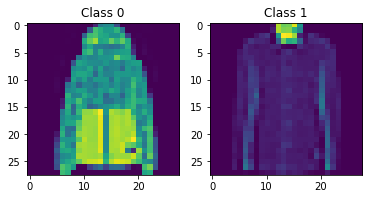

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Class 0")
ax1.imshow(Xtr[(Ytr == num_1).reshape(-1)][1])
ax2.set_title("Class 1")
ax2.imshow(Xtr[(Ytr == num_2).reshape(-1)][2])

In [128]:
batch_size= 128
epochs = 20

**Dense network experiment** 

In [129]:
# For dense network we have to transform images in vectors
Xtr = Xtr.reshape(-1, 28*28) / 255 
Xts = Xts.reshape(-1, 28*28) / 255

Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1

In [130]:
# Implement the dense network model

model = Sequential()

# Add layers
model.add(Dense(40, input_dim=28*28, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation


In [131]:
# Compile the model

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)


In [132]:
# Fit the keras model on the dataset

# Fit model
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=50,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)


Epoch 1/50
960/960 [==============================] - 2s 2ms/step - loss: 0.4307 - accuracy: 0.8050 - val_loss: 0.3131 - val_accuracy: 0.8642
Epoch 2/50
960/960 [==============================] - 2s 2ms/step - loss: 0.3165 - accuracy: 0.8673 - val_loss: 0.2926 - val_accuracy: 0.8742
Epoch 3/50
960/960 [==============================] - 2s 2ms/step - loss: 0.2826 - accuracy: 0.8800 - val_loss: 0.2672 - val_accuracy: 0.8867
Epoch 4/50
960/960 [==============================] - 2s 2ms/step - loss: 0.2611 - accuracy: 0.8916 - val_loss: 0.2530 - val_accuracy: 0.8917
Epoch 5/50
960/960 [==============================] - 2s 2ms/step - loss: 0.2411 - accuracy: 0.9026 - val_loss: 0.2914 - val_accuracy: 0.8696
Epoch 6/50
960/960 [==============================] - 2s 2ms/step - loss: 0.2343 - accuracy: 0.9022 - val_loss: 0.2445 - val_accuracy: 0.8954
Epoch 7/50
960/960 [==============================] - 2s 2ms/step - loss: 0.2251 - accuracy: 0.9105 - val_loss: 0.2288 - val_accuracy: 0.9062
Epoch 

In [133]:
# Evaluate the keras model

train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

63/63 [==============================] - 0s 1ms/step
Training error: 4.39%, Test error: 9.10%


**CNN experiment**: Repeat the previous experiment but using a CNN instead of the dense network

In [142]:
model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(28, 28, 1),activation="relu"))# add padding='same', reduce number of filters to 32
model.add(MaxPool2D(pool_size=(2,2))) # remove max 
model.add(Conv2D(64, (3,3),activation="relu")) # add padding same
model.add(MaxPool2D(pool_size=(2,2))) # remove
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

In [143]:
# Compile model
model.compile(
    loss='binary_crossentropy', 
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), 
    metrics=['accuracy'],)

In [136]:
# Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

Xtr = x_train[(y_train == num_1) | (y_train == num_2)]
Ytr = y_train[(y_train == num_1) | (y_train == num_2)]
Xts = x_test[(y_test == num_1) | (y_test == num_2)]
Yts = y_test[(y_test == num_1) | (y_test == num_2)]


Xtr = Xtr.reshape((-1, 28, 28, 1)) 
Xts = Xts.reshape((-1, 28, 28, 1)) 


Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1


In [137]:
# fit the keras model on the dataset

history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=50,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)


Epoch 1/50
960/960 [==============================] - 8s 8ms/step - loss: 0.5132 - accuracy: 0.8403 - val_loss: 0.3254 - val_accuracy: 0.8537
Epoch 2/50
960/960 [==============================] - 7s 7ms/step - loss: 0.2883 - accuracy: 0.8794 - val_loss: 0.3004 - val_accuracy: 0.8733
Epoch 3/50
960/960 [==============================] - 7s 7ms/step - loss: 0.2581 - accuracy: 0.8941 - val_loss: 0.3101 - val_accuracy: 0.8729
Epoch 4/50
960/960 [==============================] - 7s 7ms/step - loss: 0.2424 - accuracy: 0.9006 - val_loss: 0.2763 - val_accuracy: 0.8813
Epoch 5/50
960/960 [==============================] - 7s 7ms/step - loss: 0.2242 - accuracy: 0.9070 - val_loss: 0.2799 - val_accuracy: 0.8842
Epoch 6/50
960/960 [==============================] - 7s 7ms/step - loss: 0.2136 - accuracy: 0.9159 - val_loss: 0.2622 - val_accuracy: 0.8992
Epoch 7/50
960/960 [==============================] - 7s 7ms/step - loss: 0.1992 - accuracy: 0.9192 - val_loss: 0.2661 - val_accuracy: 0.9004
Epoch 

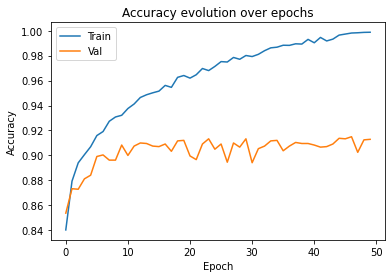

In [138]:
# Plot training history
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

In [139]:
# Evaluate the keras model
train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

63/63 [==============================] - 0s 4ms/step
Training error: 1.76%, Test error: 8.45%
